[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/Modelling.ipynb)

# Ezt csináld meg, mielőtt futtatod a notebook-ot:
- Bontsd ki az innen letölthető dolgot a home directory-ba: https://osf.io/nrgx6/
- Másold be a github repóból a python scripteket a home directory-ba: https://github.com/neuralinterfacinglab/SingleWordProductionDutch
- Lelkileg készítsd fel magad

In [ ]:
!pip install mne
!pip install -U pynwb

# Ez  cella annyira nem érdekes, de érdemes lehet ránézni
Ez a cella alapvetően a feature extraction-höz kell, de egyrészt elég alapos, másrészt nem értek hozzá, úgyhogy nem nagyon érdemes változtatgatni (esetleg később ha okosabbak leszünk).

Ez létrehoz egy features nevű mappát a home directory-ba, ami minden alanynál tartalmaz egy hangfile-t, feature táblát, a feature-ök nevét tartalmazó array-t, az adott szekvenciához tartozó szavak egy array-ét illetve a spektrogram-ot (lásd a cella alsó négy sorát).

In [ ]:
# Feature Extraction
import os

import pandas as pd
import numpy as np 
import numpy.matlib as matlib
import scipy
import scipy.signal
import scipy.stats
import scipy.io.wavfile
import scipy.fftpack

from pynwb import NWBHDF5IO
import MelFilterBank as mel

#Small helper function to speed up the hilbert transform by extending the length of data to the next power of 2
hilbert3 = lambda x: scipy.signal.hilbert(x, scipy.fftpack.next_fast_len(len(x)),axis=0)[:len(x)]

def extractHG(data, sr, windowLength=0.05, frameshift=0.01):
    """
    Window data and extract frequency-band envelope using the hilbert transform
    
    Parameters
    ----------
    data: array (samples, channels)
        EEG time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    feat: array (windows, channels)
        Frequency-band feature matrix
    """
    #Linear detrend
    data = scipy.signal.detrend(data,axis=0)
    #Number of windows
    numWindows = int(np.floor((data.shape[0]-windowLength*sr)/(frameshift*sr)))
    #Filter High-Gamma Band
    sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate first harmonic of line noise
    sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate second harmonic of line noise
    sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Create feature space
    data = np.abs(hilbert3(data))
    feat = np.zeros((numWindows,data.shape[1]))
    for win in range(numWindows):
        start= int(np.floor((win*frameshift)*sr))
        stop = int(np.floor(start+windowLength*sr))
        feat[win,:] = np.mean(data[start:stop,:],axis=0)
    return feat

def stackFeatures(features, modelOrder=4, stepSize=5):
    """
    Add temporal context to each window by stacking neighboring feature vectors
    
    Parameters
    ----------
    features: array (windows, channels)
        Feature time series
    modelOrder: int
        Number of temporal context to include prior to and after current window
    stepSize: float
        Number of temporal context to skip for each next context (to compensate for frameshift)
    Returns
    ----------
    featStacked: array (windows, feat*(2*modelOrder+1))
        Stacked feature matrix
    """
    featStacked=np.zeros((features.shape[0]-(2*modelOrder*stepSize),(2*modelOrder+1)*features.shape[1]))
    for fNum,i in enumerate(range(modelOrder*stepSize,features.shape[0]-modelOrder*stepSize)):
        ef=features[i-modelOrder*stepSize:i+modelOrder*stepSize+1:stepSize,:]
        featStacked[fNum,:]=ef.flatten() #Add 'F' if stacked the same as matlab
    return featStacked

def downsampleLabels(labels, sr, windowLength=0.05, frameshift=0.01):
    """
    Downsamples non-numerical data by using the mode
    
    Parameters
    ----------
    labels: array of str
        Label time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which mode will be used
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    newLabels: array of str
        Downsampled labels
    """
    numWindows=int(np.floor((labels.shape[0]-windowLength*sr)/(frameshift*sr)))
    newLabels = np.empty(numWindows, dtype="S15")
    for w in range(numWindows):
        start = int(np.floor((w*frameshift)*sr))
        stop = int(np.floor(start+windowLength*sr))
        newLabels[w]=scipy.stats.mode(labels[start:stop])[0][0].encode("ascii", errors="ignore").decode()
    return newLabels

def extractMelSpecs(audio, sr, windowLength=0.05, frameshift=0.01):
    """
    Extract logarithmic mel-scaled spectrogram, traditionally used to compress audio spectrograms
    
    Parameters
    ----------
    audio: array
        Audio time series
    sr: int
        Sampling rate of the audio
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    numFilter: int
        Number of triangular filters in the mel filterbank
    Returns
    ----------
    spectrogram: array (numWindows, numFilter)
        Logarithmic mel scaled spectrogram
    """
    numWindows=int(np.floor((audio.shape[0]-windowLength*sr)/(frameshift*sr)))
    win = np.hanning(np.floor(windowLength*sr + 1))[:-1]
    spectrogram = np.zeros((numWindows, int(np.floor(windowLength*sr / 2 + 1))),dtype='complex')
    for w in range(numWindows):
        start_audio = int(np.floor((w*frameshift)*sr))
        stop_audio = int(np.floor(start_audio+windowLength*sr))
        a = audio[start_audio:stop_audio]
        spec = np.fft.rfft(win*a)
        spectrogram[w,:] = spec
    mfb = mel.MelFilterBank(spectrogram.shape[1], 23, sr)
    spectrogram = np.abs(spectrogram)
    spectrogram = (mfb.toLogMels(spectrogram)).astype('float')
    return spectrogram

def nameVector(elecs, modelOrder=4):
    """
    Creates list of electrode names
    
    Parameters
    ----------
    elecs: array of str
        Original electrode names
    modelOrder: int
        Temporal context stacked prior and after current window
        Will be added as T-modelOrder, T-(modelOrder+1), ...,  T0, ..., T+modelOrder
        to the elctrode names
    Returns
    ----------
    names: array of str
        List of electrodes including contexts, will have size elecs.shape[0]*(2*modelOrder+1)
    """
    names = matlib.repmat(elecs.astype(np.dtype(('U', 10))),1,2 * modelOrder +1).T
    for i, off in enumerate(range(-modelOrder,modelOrder+1)):
        names[i,:] = [e[0] + 'T' + str(off) for e in elecs]
    return names.flatten()  #Add 'F' if stacked the same as matlab


if __name__=="__main__":
    winL = 0.05
    frameshift = 0.01
    modelOrder = 4
    stepSize = 5
    path_bids = r'./SingleWordProductionDutch-iBIDS'
    path_output = r'./features'
    participants = pd.read_csv(os.path.join(path_bids,'participants.tsv'), delimiter='\t')
    for p_id, participant in enumerate(participants['participant_id']):
        
        #Load data
        io = NWBHDF5IO(os.path.join(path_bids,participant,'ieeg',f'{participant}_task-wordProduction_ieeg.nwb'), 'r')
        nwbfile = io.read()
        #sEEG
        eeg = nwbfile.acquisition['iEEG'].data[:]
        eeg_sr = 1024
        #audio
        audio = nwbfile.acquisition['Audio'].data[:]
        audio_sr = 48000
        #words (markers)
        words = nwbfile.acquisition['Stimulus'].data[:]
        words = np.array(words, dtype=str)
        io.close()
        #channels
        channels = pd.read_csv(os.path.join(path_bids,participant,'ieeg',f'{participant}_task-wordProduction_channels.tsv'), delimiter='\t')
        channels = np.array(channels['name'])

        #Extract HG features
        feat = extractHG(eeg,eeg_sr, windowLength=winL,frameshift=frameshift)

        #Stack features
        feat = stackFeatures(feat,modelOrder=modelOrder,stepSize=stepSize)
        
        #Process Audio
        target_SR = 16000
        audio = scipy.signal.decimate(audio,int(audio_sr / target_SR))
        audio_sr = target_SR
        scaled = np.int16(audio/np.max(np.abs(audio)) * 32767)
        os.makedirs(os.path.join(path_output), exist_ok=True)
        scipy.io.wavfile.write(os.path.join(path_output,f'{participant}_orig_audio.wav'),audio_sr,scaled)   

        #Extract spectrogram
        melSpec = extractMelSpecs(scaled,audio_sr,windowLength=winL,frameshift=frameshift)
        
        #Align to EEG features
        melSpec = melSpec[modelOrder*stepSize:melSpec.shape[0]-modelOrder*stepSize,:]
        #adjust length (differences might occur due to rounding in the number of windows)
        if melSpec.shape[0]!=feat.shape[0]:
            tLen = np.min([melSpec.shape[0],feat.shape[0]])
            melSpec = melSpec[:tLen,:]
            feat = feat[:tLen,:]
        
        #Create feature names by appending the temporal shift 
        feature_names = nameVector(channels[:,None], modelOrder=modelOrder)

        #Save everything
        np.save(os.path.join(path_output,f'{participant}_feat.npy'), feat)
        np.save(os.path.join(path_output,f'{participant}_procWords.npy'), words)
        np.save(os.path.join(path_output,f'{participant}_spec.npy'), melSpec)
        np.save(os.path.join(path_output,f'{participant}_feat_names.npy'), feature_names)

C:\Users\DONT~1\AppData\Local\Temp/ipykernel_5112/789610502.py:131: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  win = scipy.hanning(np.floor(windowLength*sr + 1))[:-1]


# Innen jön az, amit érdemes tanulmányozni
Az első az a Wav rekonstrukcióját írja le mindenféle Fourier trafóval (ha akarsz egy jó videót nézni a témában, akkor ajánlom Junferno "To Become Vocaloid" című videóját), a másik magát az audiónak a rekonstrukcióját illetve az odavezető modellezést. Elég sok állítható paraméter van (pl. PCA-nál a főkomponensszám, illetve ICA-t is érdemes lehet használni). Az eredményeknek egy 'results' nevű mappát hoz létre a home directory-ban.

Length of wavefile in samples 160000
Sampling rate is 16000
Shape of complex spectrum is (621, 513)


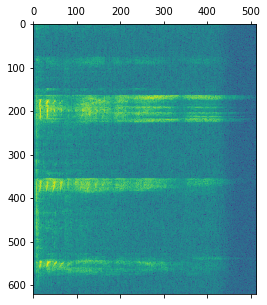

C:\Users\DONT~1\AppData\Local\Temp/ipykernel_5112/253311772.py:18: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  x = scipy.zeros(X.shape[0]*hop)
C:\Users\DONT~1\AppData\Local\Temp/ipykernel_5112/253311772.py:19: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  wsum = scipy.zeros(X.shape[0]*hop)
C:\Users\DONT~1\AppData\Local\Temp/ipykernel_5112/253311772.py:21: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  x[i:i+fftsize] += scipy.real(np.fft.irfft(X[n])) * w   # overlap-add


0.5690004825592041


In [ ]:
# Wave reconstruction
import scipy, numpy as np
import scipy.io.wavfile as wavefile

def stft(x, fftsize=1024, overlap=4):
    """Returns short time fourier transform of a signal x
    """
    hop = int(fftsize / overlap)
    w = np.hanning(fftsize+1)[:-1]      # better reconstruction with this trick +1)[:-1]
    return np.array([np.fft.rfft(w*x[i:i+int(fftsize)]) for i in range(0, len(x)-int(fftsize), hop)])

def istft(X, overlap=4):
    """Returns inverse short time fourier transform of a complex spectrum X
    """
    fftsize=(X.shape[1]-1)*2
    hop = int(fftsize / overlap)
    w = np.hanning(fftsize+1)[:-1]
    x = scipy.zeros(X.shape[0]*hop)
    wsum = scipy.zeros(X.shape[0]*hop)
    for n,i in enumerate(range(0, len(x)-fftsize, hop)):
        x[i:i+fftsize] += scipy.real(np.fft.irfft(X[n])) * w   # overlap-add
        wsum[i:i+fftsize] += w ** 2.
    #Could be improved
    #pos = wsum != 0
    #x[pos] /= wsum[pos]
    return x

def reconstructWavFromSpectrogram(spec,lenWaveFile,fftsize=1024,overlap=4,numIterations=8):
    """Returns a reconstructed waveform from the spectrogram
    using the method in
    Griffin, Lim: Signal estimation from modified short-time Fourier transform,
    IEEE Transactions on Acoustics Speech and Signal Processing, 1984
    algo described here:
    Bayram, Ilker. "An analytic wavelet transform with a flexible time-frequency covering."
    Signal Processing, IEEE Transactions on 61.5 (2013): 1131-1142.
    """
    reconstructedWav = np.random.rand(lenWaveFile*2)
    #while(stft(reconstructedWav,fftsize=fftsize,overlap=overlap).shape[0]<spec.shape[0]):
    #    print(spec.shape[0]-stft(reconstructedWav,fftsize=fftsize,overlap=overlap).shape[0])
    #    lenWaveFile += 1
    #    reconstructedWav = np.random.rand(lenWaveFile)


    for i in range(numIterations):
        x=stft(reconstructedWav,fftsize=fftsize,overlap=overlap)
        #print(str(x.shape) + '  ' + str(spec.shape))
        z=spec*np.exp(1j*np.angle(x[:spec.shape[0],:])) #[:spec.shape[0],:spec.shape[1]]
        re=istft(z,overlap=overlap)
        reconstructedWav[:len(re)]=re
    reconstructedWav=reconstructedWav[:len(re)]
    return reconstructedWav


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    # ITT EGY PÉLDA AUDIO VAN, NYUGODTAN LEHET VÁLTOZTATNI
    (sr,wf) = wavefile.read('./features/sub-01_orig_audio.wav')                 # példának
    wf = wf[10*sr:20*sr]
    print('Length of wavefile in samples ' + str(wf.shape[0]))
    print('Sampling rate is ' + str(sr))
    x=stft(wf)
    print('Shape of complex spectrum is ' + str(x.shape))
    spectrogram=np.abs(x)
    plt.matshow(np.log(spectrogram),aspect='auto')
    plt.show()
    import time
    t=time.time()
    data = reconstructWavFromSpectrogram(spectrogram,len(wf))
    print(time.time()-t)
    #plt.plot(wf, 'b',data,'r')
    #plt.show()
    #Save reconstructed file
    wavefile.write('orig.wav',sr,wf)
    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    wavefile.write('test.wav',sr,scaled)
    #wavefile.write('test_orig.wav',sr,wf)

In [ ]:
# Reconstruction minimal
import os

import numpy as np
import scipy.io.wavfile as wavfile
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import reconstructWave as rW
import MelFilterBank as mel


def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    """
    Create a reconstructed audio wavefrom
    
    Parameters
    ----------
    spectrogram: array
        Spectrogram of the audio
    sr: int
        Sampling rate of the audio
    windowLength: float
        Length of window (in seconds) in which spectrogram was calculated
    frameshift: float
        Shift (in seconds) after which next window was extracted
    Returns
    ----------
    scaled: array
        Scaled audio waveform
    """
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    nfolds = 10
    hop = int(spectrogram.shape[0]/nfolds)
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled


if __name__=="__main__":
    feat_path = r'./features'
    result_path = r'./results'
    pts = ['sub-%02d'%i for i in range(1,11)]

    winLength = 0.05
    frameshift = 0.01
    audiosr = 16000

    nfolds = 10
    kf = KFold(nfolds,shuffle=False)
    est = LinearRegression(n_jobs=5)
    pca = PCA()
    numComps = 50
    
    #Initialize empty matrices for correlation results, randomized contols and amount of explained variance
    allRes = np.zeros((len(pts),nfolds,23))
    explainedVariance = np.zeros((len(pts),nfolds))
    numRands = 1000
    randomControl = np.zeros((len(pts),numRands, 23))

    for pNr, pt in enumerate(pts):
        
        
        #Load the data
        #Dimensions of these data vary depending on the subject
        spectrogram = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))  
        data = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))
        labels = np.load(os.path.join(feat_path,f'{pt}_procWords.npy'))
        featName = np.load(os.path.join(feat_path,f'{pt}_feat_names.npy'))
        
        #Initialize an empty spectrogram to save the reconstruction to
        rec_spec = np.zeros(spectrogram.shape)
        #Save the correlation coefficients for each fold
        rs = np.zeros((nfolds,spectrogram.shape[1]))
        for k,(train, test) in enumerate(kf.split(data)):
            #Z-Normalize with mean and std from the training data
            mu=np.mean(data[train,:],axis=0)
            std=np.std(data[train,:],axis=0)
            trainData=(data[train,:]-mu)/std
            testData=(data[test,:]-mu)/std

            #Fit PCA to training data
            pca.fit(trainData)
            #Get percentage of explained variance by selected components
            explainedVariance[pNr,k] =  np.sum(pca.explained_variance_ratio_[:numComps])
            #Tranform data into component space
            trainData=np.dot(trainData, pca.components_[:numComps,:].T)
            testData = np.dot(testData, pca.components_[:numComps,:].T)
            
            #Fit the regression model
            est.fit(trainData, spectrogram[train, :])
            #Predict the reconstructed spectrogram for the test data
            rec_spec[test, :] = est.predict(testData)

            #Evaluate reconstruction of this fold
            for specBin in range(spectrogram.shape[1]):
                if np.any(np.isnan(rec_spec)):
                    print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
                r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
                rs[k,specBin] = r

        #Show evaluation result
        print('%s has mean correlation of %f' % (pt, np.mean(rs)))
        allRes[pNr,:,:]=rs

        #Estimate random baseline
        for randRound in range(numRands):
            #Choose a random splitting point at least 10% of the dataset size away
            splitPoint = np.random.choice(np.arange(int(spectrogram.shape[0]*0.1),int(spectrogram.shape[0]*0.9)))
            #Swap the dataset on the splitting point 
            shuffled = np.concatenate((spectrogram[splitPoint:,:],spectrogram[:splitPoint,:]))
            #Calculate the correlations
            for specBin in range(spectrogram.shape[1]):
                if np.any(np.isnan(rec_spec)):
                    print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
                r, p = pearsonr(spectrogram[:,specBin], shuffled[:,specBin])
                randomControl[pNr, randRound,specBin]=r


        #Save reconstructed spectrogram
        os.makedirs(os.path.join(result_path), exist_ok=True)
        np.save(os.path.join(result_path,f'{pt}_predicted_spec.npy'), rec_spec)
        
        #Synthesize waveform from spectrogram using Griffin-Lim
        reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
        wavfile.write(os.path.join(result_path,f'{pt}_predicted.wav'),int(audiosr),reconstructedWav)

        #For comparison synthesize the original spectrogram with Griffin-Lim
        origWav = createAudio(spectrogram,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
        wavfile.write(os.path.join(result_path,f'{pt}_orig_synthesized.wav'),int(audiosr),origWav)

    #Save results in numpy arrays          
    np.save(os.path.join(result_path,'linearResults.npy'),allRes)
    np.save(os.path.join(result_path,'randomResults.npy'),randomControl)
    np.save(os.path.join(result_path,'explainedVariance.npy'),explainedVariance)

sub-01 has mean correlation of 0.519977
sub-02 has mean correlation of 0.632364
sub-03 has mean correlation of 0.837003
sub-04 has mean correlation of 0.780109
sub-05 has mean correlation of 0.532358
sub-06 has mean correlation of 0.861970
sub-07 has mean correlation of 0.707043
sub-08 has mean correlation of 0.715179
sub-09 has mean correlation of 0.657480
sub-10 has mean correlation of 0.692957


## Ez csak a cikkben használt képek vizualizációja, de hasznos lehet, ha mi is ilyet akarunk csinálni.

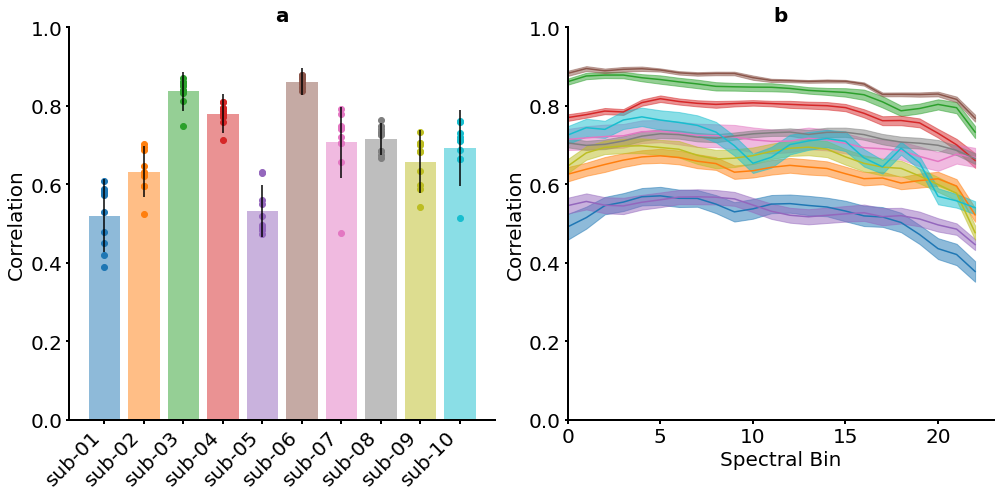

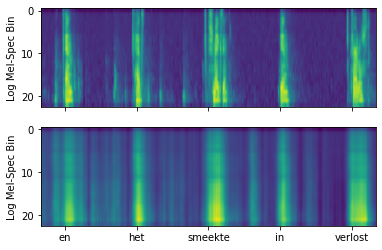

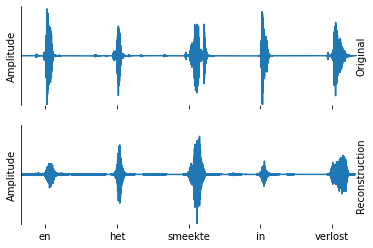

In [ ]:
# Visualization
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

if __name__=="__main__":
    
    result_path = r'./results'
    #Load correlation results
    allRes = np.load(os.path.join(result_path,'linearResults.npy'))

    colors = ['C' + str(i) for i in range(10)]

    meanCorrs = np.mean(allRes,axis=(1,2))
    stdCorrs = np.std(allRes, axis=(1,2))

    x = range(len(meanCorrs))
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    #Barplot of average results
    ax[0].bar(x,meanCorrs,yerr=stdCorrs,alpha=0.5,color=colors)
    for p in range(allRes.shape[0]):
        #Add mean results of each patient as scatter points
        ax[0].scatter(np.zeros(allRes[p,:,:].shape[0])+p,np.mean(allRes[p,:,:],axis=1),color=colors[p])

    ax[0].set_xticks(x)
    ax[0].set_xticklabels(['sub-' + "{:02d}".format(i+1) for i in x],rotation=45, ha='right',fontsize=20)
    ax[0].set_ylim(0,1)
    ax[0].set_ylabel('Correlation')
    #Title
    ax[0].set_title('a',fontsize=20,fontweight="bold")
    # Make pretty
    plt.setp(ax[0].spines.values(), linewidth=2)
    #The ticks
    ax[0].xaxis.set_tick_params(width=2)
    ax[0].yaxis.set_tick_params(width=2)
    ax[0].xaxis.label.set_fontsize(20)
    ax[0].yaxis.label.set_fontsize(20)
    c = [a.set_fontsize(20) for a in ax[0].get_yticklabels()]

    #Despine
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)

    #Mean across folds over spectral bins
    specMean = np.mean(allRes,axis=1)
    specStd = np.std(allRes,axis=1)
    specBins = np.arange(allRes.shape[2])
    for p in range(allRes.shape[0]):
        ax[1].plot(specBins, specMean[p,:],color=colors[p])
        error = specStd[p,:]/np.sqrt(allRes.shape[1])
        #Shaded areas highlight standard error
        ax[1].fill_between(specBins,specMean[p,:]-error,specMean[p,:]+error,alpha=0.5,color=colors[p])
    ax[1].set_ylim(0,1)
    ax[1].set_xlim(0,len(specBins))
    ax[1].set_xlabel('Spectral Bin')
    ax[1].set_ylabel('Correlation')
    #Title
    ax[1].set_title('b',fontsize=20,fontweight="bold")

    #Make pretty
    plt.setp(ax[1].spines.values(), linewidth=2)
    #The ticks
    ax[1].xaxis.set_tick_params(width=2)
    ax[1].yaxis.set_tick_params(width=2)
    ax[1].xaxis.label.set_fontsize(20)
    ax[1].yaxis.label.set_fontsize(20)
    c = [a.set_fontsize(20) for a in ax[1].get_yticklabels()]
    c = [a.set_fontsize(20) for a in ax[1].get_xticklabels()]
    #Despine
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path,'results.png'),dpi=600)
    plt.show()

    # Viz example spectrogram
    #Load words and spectrograms
    feat_path = r'./features'
    participant = 'sub-06'
    #Which timeframe to plot
    start_s = 5.5
    stop_s=19.5

    frameshift = 0.01
    #Load spectrograms
    rec_spec = np.load(os.path.join(result_path, f'{participant}_predicted_spec.npy'))
    spectrogram = np.load(os.path.join(feat_path, f'{participant}_spec.npy'))
    #Load prompted words
    eeg_sr= 1024
    words = np.load(os.path.join(feat_path,f'{participant}_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
    words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']
    
    cm='viridis'
    fig, ax = plt.subplots(2, sharex=True)
    #Plot spectrograms
    pSta=int(start_s*(1/frameshift));pSto=int(stop_s*(1/frameshift))
    ax[0].imshow(np.flipud(spectrogram[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
    ax[0].set_ylabel('Log Mel-Spec Bin')
    ax[1].imshow(np.flipud(rec_spec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
    plt.setp(ax[1], xticks=np.arange(0,pSto-pSta,int(1/frameshift)), xticklabels=[str(x/int(1/frameshift)) for x in np.arange(0,pSto-pSta,int(1/frameshift))])
    plt.setp(ax[1], xticks=np.arange(int(1/frameshift),spectrogram[pSta:pSto, :].shape[0],3*int(1/frameshift)), xticklabels=words)
    ax[1].set_ylabel('Log Mel-Spec Bin')

    plt.savefig(os.path.join(result_path,'spec_example.png'),dpi=600)

    #Saving for use in Adobe Illustrator
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig(os.path.join(result_path,'spec_example.pdf'),transparent=True)
    plt.show()


    # Viz waveforms
    #Load waveforms
    rate, audio = wavfile.read(os.path.join(result_path,f'{participant}_orig_synthesized.wav'))
    rate, recAudio = wavfile.read(os.path.join(result_path,f'{participant}_predicted.wav'))
    
    orig = audio[int(start_s*rate):int(stop_s*rate)]
    rec = recAudio[int(start_s*rate):int(stop_s*rate)]
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(orig)
    axarr[1].plot(rec)

    #Axis
    xts = np.arange(rate,orig.shape[0]+1,3*rate)
    axarr[1].set_xticks(xts)
    axarr[1].set_xticklabels(words)
    axarr[0].set_xlim([0,orig.shape[0]])
    axarr[0].set_ylim([-np.max(np.abs(orig)),np.max(np.abs(orig))])
    axarr[1].set_ylim([-np.max(np.abs(rec)),np.max(np.abs(rec))])
    
    #Add line indicating 3 seconds
    axarr[1].annotate("",xy=(xts[0], 27000), xycoords='data',xytext=(xts[1],27000), textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3"),
                )
    axarr[1].annotate("3 seconds",xy=((xts[0]+xts[1])/2, 22000), horizontalalignment='center')

    #Axis labels
    axarr[0].set_ylabel('Original')
    axarr[0].set_yticks([])
    axarr[1].set_yticks([])
    axarr[1].set_ylabel('Amplitude')
    axarr[0].set_ylabel('Amplitude')
    axarr[1].text(orig.shape[0],0,'Reconstruction',horizontalalignment='left',verticalalignment='center',rotation='vertical',)
    axarr[0].text(orig.shape[0],0,'Original',horizontalalignment='left',verticalalignment='center',rotation='vertical',)

    #Make Pretty
    ax[1].xaxis.set_tick_params(width=2)
    ax[1].yaxis.set_tick_params(width=2)
    ax[1].xaxis.label.set_fontsize(20)
    ax[1].yaxis.label.set_fontsize(20)
    c = [a.set_fontsize(20) for a in ax[1].get_yticklabels()]
    c = [a.set_fontsize(20) for a in ax[1].get_xticklabels()]
    #ax.get_yticklabels().set_fontsize(28)

    #Despine
    for axes in axarr:
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        #axes.spines['top'].set_visible(False)

    plt.savefig(os.path.join(result_path,'wav_example.png'),dpi=600)
    #Saving for usage in Adobe Illustrator
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig(os.path.join(result_path,'wav_example.pdf'),transparent = True)
    plt.show()

# Innen jönnek a mi szánalmas próbálkozásaink

Ha valami nem tiszta, Donát bácsi elmagyarázza, ha már annyit szopott vele, hogy megértse.

In [ ]:
# Az ötödik alany dolgai

feat_path = r'./features'
pt = 'sub-05'
spectrogram = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))
data = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))
labels = np.load(os.path.join(feat_path,f'{pt}_procWords.npy'))
featName = np.load(os.path.join(feat_path,f'{pt}_feat_names.npy'))

In [ ]:
data.shape

(29984, 540)

In [ ]:
# Keresztvalidáció és lineáris regresszió

nfolds = 10
kf = KFold(nfolds,shuffle=False)
est = LinearRegression(n_jobs=5)
pca = PCA()
numComps = 50

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
    #Z-Normalize with mean and std from the training data
    mu=np.mean(data[train,:],axis=0)
    std=np.std(data[train,:],axis=0)
    trainData=(data[train,:]-mu)/std
    testData=(data[test,:]-mu)/std

    #Fit PCA to training data
    pca.fit(trainData)
    #Get percentage of explained variance by selected components
    explainedVariance[pNr,k] =  np.sum(pca.explained_variance_ratio_[:numComps])
    #Tranform data into component space
    trainData=np.dot(trainData, pca.components_[:numComps,:].T)
    testData = np.dot(testData, pca.components_[:numComps,:].T)
            
    #Fit the regression model
    est.fit(trainData, spectrogram[train, :])
    #Predict the reconstructed spectrogram for the test data
    rec_spec[test, :] = est.predict(testData)

    #Evaluate reconstruction of this fold
    #Ez a rész nem kell a predikcióhoz, csak a kiértékeléshez használt pearsson korreláció kiszámolásához
    for specBin in range(spectrogram.shape[1]):
        if np.any(np.isnan(rec_spec)):
            print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
        r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
        rs[k,specBin] = r

In [ ]:
spectrogram[train, :].shape

(26986, 23)

Alapból nekünk ehelyett kéne neurális háló:

In [ ]:
"""

#Fit the regression model
est.fit(trainData, spectrogram[train, :])
#Predict the reconstructed spectrogram for the test data
rec_spec[test, :] = est.predict(testData)

"""

Aminek a bemenete nyilván a trainData.shape[1] alakú, a kimenete pedig spectrogram.shape[1] alakú. Ez lehet sima Dense, Autoencoder, 1D-s konvolúció stb., mindenki kiválasztja a saját perverzióját.

Első körben egy beszélőre kéne ezt optimalizálni, ha pedig ez megvan, akkor a többi beszélővel továbbtanítani.

A 'Reconstruction Minimal' és 'Feature Extraction' kódok alapján maga a tanító, validációs és teszthalmzara bontás elég egyszerűen megvalósítható, miután minden alanyra elvégeztük a feature extraction-t és a PCA-t, szóval azzal nem lesz gond.

### A beszédspektrogram-rekonstrukció keresztvalidációs működése:
- Egy adatrekordnál van ugye az eredeti audióhoz tartozó spektrogram egy adott része (23 dimenziós), ami kvázi a célváltozók halmaza, és ezen kívül az ehhez nyert feature vektor az agyhullámokból, ami már PCA-sítva lett.
- Először létrehoz egy, a spektrogrammal megegyező nagyságú nullvektort (pontosabban mátrixot, ez a 'res_spec'), ez lesz részenként update-elve a megfelelő spektrogramrészletekkel.
- A feature vektorokat tartalmazó halmazt felosztja k (jelen esetben 10) részre, amiből k-1 rész a tanítóhalmaz és 1 a teszthalmaz, és ez iterálva változik k alkalommal (csak úgy, mint keresztvalidációnál). Először nézzünk egy iterációt:
- A tanítóhalmazt betanítja a spektrogram vele megfelelő indexű részein, és a tanított modellt alkalmazza a teszthalmazra.
- A prediktált spektrogramrészletet beilleszti a kezdeti nullvetkor teszthalmazzal megegyező indexű részeire.
- Közben kiszámolja a korrelációt a prediktált és a valódi részlet közötti Pearsson korrelációt.
- Ezt csinálja k-szor, amíg el nem készül a teljes rekonstruált spektrogram, amiből végül audio-t csinál. Utólag kiszámolja az átlagos pearrson korrelációt is azokból a korrelációkból, amelyek az egyes részekhez tartoztak.

Csinál ezen kívül valami random baseline korrelációszámítást is, de ennek egyelőre nem látom az értelmét a cikk elolvasása után sem, szóval ezt egyelőre hanyagoljuk.

<b>Szerintem amit csinálnunk kell elsősroban:</b> Kicsit jobban megnézni, hogy a feature extraction hogyan működik (a cikkben ez kb le van írva, de egy csomó eljárás, amit annál használnak, nincs kifejtve); optimalizálható részek keresése; Irodalom átnézése (ilyen típúsú beszédrekonstrokcióról kevés van, de pl. a fourier trafókhóz is lehet nézni)